# Feature engineering

_________________________________________________________________________________

**Reference file:**
- combined_data.json
- [reviews]?

**Problem:** 
- Predicting the price or price range of the product

__________________________________________________________________________________

## 1.0 Loading file

In [64]:
#Import necessary libraries
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
with open('../data/processed_data/combined_data.json', 'r') as file:
    data= json.load(file)
df=pd.DataFrame.from_dict(data)

In [3]:
df.head().T

,0,1,2,3,4
brand,Glow Recipe,Tatcha,goop,CLINIQUE,Tata Harper
product_name,Glow Recipe Watermelon Glow PHA +BHA Pore-Tigh...,Tatcha Pure One Step Camellia Oil Cleanser,goop GOOPGLOW Microderm Instant Glow Exfoliator,CLINIQUE Take The Day Off Makeup Remover For L...,Tata Harper Regenerating Exfoliating Cleanser
product_type,toners,face wash and cleansers,exfoliators and peels,face wash and cleansers,face wash and cleansers
num_likes,125100,107600,12900,76700,31000
rating,4.5,4.5,4.5,4.5,4.5
num_reviews,1900,1700,1200,3100,567
sensitive_type,0,1,0,0,0
combination_type,1,1,1,0,1
oily_type,1,1,1,0,0
normal_type,1,1,1,0,0


## 2.0 Feature engineering

**Encode categorical columns**

In [4]:
df= pd.get_dummies(df, columns=['formulation_type', 'richness', 'product_type', 'brand']
              #drop_first=True
              )

**Created alternative y variables**

In [5]:
#Create category based on quantiles
df['affordability']= pd.qcut(df.pricepervol, q=4, labels=['$', '$$', '$$$', '$$$$'], duplicates='raise')

In [6]:
df['affordability'].value_counts()

$$$     340
$       337
$$      334
$$$$    327
Name: affordability, dtype: int64

In [7]:
#Identify outliers
IQR = np.quantile(df.pricepervol, 0.75) - np.quantile(df.pricepervol, 0.25)
np.quantile(df.pricepervol, 0.25) -1.5*(IQR), np.quantile(df.pricepervol, 0.25) +1.5*(IQR) 

(-83.025, 103.005)

For simplicity, 0-100 will be used instead to create the bins.

In [8]:
#Create categories based on bins
df['affordability_bins']=pd.cut(df.pricepervol, bins=[0, 25, 50, 75, 100, 885], labels=['1st', '2nd', '3rd', '4th', '5th'], include_lowest=True)

## Saving the cleaned dataset before splitting

In [65]:
datapath = '../data/processed_data'
datapath_df = os.path.join(datapath, 'pre_modelling_df.json')
if not os.path.exists(datapath_df):
    df.to_json(datapath_df)

## 3.0 Train-test split

In [37]:
targeted_var = 'pricepervol'
excluded_features = ['product_name', 
                    #y values 
                     'pricepervol', 'affordability', 'affordability_bins',
                     'highlighted_ingr', 'ingr_list'
                    ]

In [38]:
X= df.drop(columns=excluded_features)
y= df[targeted_var]

In [39]:
df.columns

Index(['product_name', 'num_likes', 'rating', 'num_reviews', 'sensitive_type',
       'combination_type', 'oily_type', 'normal_type', 'dry_type',
       'clean_sephora',
       ...
       'brand_belif', 'brand_fresh', 'brand_goop', 'brand_innisfree',
       'brand_lilah b.', 'brand_philosophy', 'brand_rms beauty', 'brand_tarte',
       'affordability', 'affordability_bins'],
      dtype='object', length=181)

In [40]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size= 0.3, random_state=12)

In [41]:
X_tr.shape, X_te.shape

((936, 175), (402, 175))

## 4.0 Transforming the features

In [60]:
#Create a copy of datasets
X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()

In [61]:
target_cols = ['num_likes', 'num_reviews']

for i in target_cols:
    # fit on training data column
    scaler = StandardScaler().fit(X_tr_scaled[[i]])
    
    # transform the training data column
    X_tr_scaled[i] = scaler.transform(X_tr_scaled[[i]])
    
    # transform the testing data column
    X_te_scaled[i] = scaler.transform(X_te_scaled[[i]])

<font color='red'> To confirm, I see some notebooks which transform the entire dataset. I assume we only have to transform certain features - i.e. those with varying ranges? 
    
also, if I used a standardscaler in my pipeline, then it would transform the entire dataset right? 
    
</font>

__________________________________

# Modelling

## 1.0 Loading the files

In [69]:
#Importing required packages
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
#from library.sb_utils import save_file

## 2.0 Building initial / baseline models

### 2.1 Mean as predictor

In [115]:
method= 'median' #can also try other methods: median, most frequent/mode

In [116]:
dumb_reg = DummyRegressor(strategy=method) 
dumb_reg.fit(X_tr_scaled, y_tr)
dumb_reg.constant_

array([[32.94117647]])

In [117]:
y_tr_pred = dumb_reg.predict(X_tr_scaled)

In [118]:
#Model will predict the same value everytime
y_te_pred = float(dumb_reg.constant_) * np.ones(len(y_te))

In [122]:
print(f'Assessing the model performance using a {method} baseline')
print('\n')
print('R2 score')
print(f'Training set: {round(r2_score(y_tr, y_tr_pred),4)}')
print(f'Testing set: {round(r2_score(y_te, y_te_pred),4)}')
print('\n')
print('Mean Absolute Error (MAE)')
print(f'Training set: {round(mean_absolute_error(y_tr, y_tr_pred),4)}')
print(f'Testing set: {round(mean_absolute_error(y_te, y_te_pred),4)}')
print('\n')
print('Root Mean Squared Error (RMSE)')
print(f'Training set: {round(np.sqrt(mean_squared_error(y_tr, y_tr_pred)),4)}')
print(f'Testing set: {round(np.sqrt(mean_squared_error(y_te, y_te_pred)),4)}')

Assessing the model performance using a median baseline


R2 score
Training set: -0.1033
Testing set: -0.0674


Mean Absolute Error (MAE)
Training set: 42.0562
Testing set: 41.2134


Root Mean Squared Error (RMSE)
Training set: 72.1162
Testing set: 84.0184


**[Comment]**

### 2.2 Linear Regression

In [123]:
linreg = LinearRegression().fit(X_tr_scaled, y_tr)
y_tr_pred = linreg.predict(X_tr_scaled)
y_te_pred = linreg.predict(X_te_scaled)

In [141]:
print(f' R2 Score: {round(linreg.score(X_tr_scaled, y_tr),4)}')

 R2 Score: 0.6549


In [144]:
print('Coefficients: \n', linreg.coef_)
print('Intercept: \n', linreg.intercept_)

Coefficients: 
 [-2.30586521e+00 -6.58787030e+00 -1.20312935e-01 -3.94416984e+00
  4.55827121e+00 -5.22836224e+00 -8.03259543e+00  5.06714301e-01
 -1.11177525e+01 -1.23923905e+01  6.33119029e+00 -1.04018623e-01
  7.79183033e+00  4.34681320e-01  2.75690520e+00  2.44613505e+01
  2.58306054e+00  4.16436565e+00 -5.47932542e+00  1.23644709e+00
 -1.75392805e+01 -3.96166865e-02  1.10948169e+01  1.22136897e+00
  1.52518555e+01  1.62667379e+00  5.61700918e+00 -6.24983769e+00
 -1.16369068e+01 -4.89062995e+00  1.23234632e+14  1.23234632e+14
  1.23234632e+14  1.23234632e+14  1.23234632e+14  1.23234632e+14
  1.23234632e+14  1.64343058e+14  1.64343058e+14  1.64343058e+14
  1.77545043e+14  1.77545043e+14  1.77545043e+14  1.77545043e+14
  1.77545043e+14  1.77545043e+14  7.75646938e+12  7.75646938e+12
  7.75646938e+12 -5.46647616e+11  6.03029844e+10  7.75646938e+12
  7.75646938e+12  7.75646938e+12  7.75646938e+12  7.75646938e+12
  7.75646938e+12  7.75646938e+12  7.75646938e+12 -4.54372482e+10
  7.75646

In [147]:
print('MSE: %.2f' % np.sqrt(mean_squared_error(y_te, y_te_pred)))
print('R2: %.2f'% r2_score(y_te, y_te_pred))

MSE: 1454819974673.91
R2: -320025240411888353280.00


<font color='red'> How is it possible that we have the results above?? 

add r2 
    
add comment

</font>

#### 2.2.1 Refining the linear regression

Make the pipeline

In [184]:
pipeline = make_pipeline(
    #SimpleImputer(strategy='median'), 
    #StandardScaler(),
    SelectKBest(score_func=f_regression, k=50),
    LinearRegression()
)

In [185]:
cv_results = cross_validate(pipeline, X_tr_scaled, y_tr, cv=5)
cv_scores = cv_results['test_score']

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [186]:
np.mean(cv_scores), np.std(cv_scores)

(0.5140515328407748, 0.08002966931022792)

Find optimal parameters using GridSearchCV

In [187]:
k = [k+1 for k in range(len(X_tr_scaled.columns))]
grid_params = {'selectkbest__k': k}

In [188]:
lr_grid_cv = GridSearchCV(pipeline, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_tr_scaled, y_tr)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(k=50,
                                                    score_func=<function f_regression at 0x124e47550>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [189]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [190]:
lr_grid_cv.best_params_

{'selectkbest__k': 111}

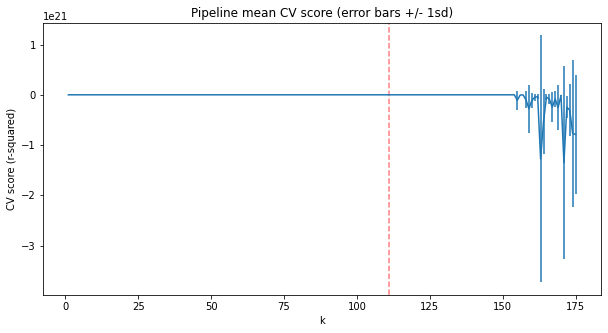

In [191]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');